In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from os import path
from linear_opt.lin_metabolism import LinearMetabolicModel

from SALib import ProblemSpec

In [2]:
model_dir = '../models/linear/respiration/'
m_fname = path.join(model_dir, 'glucose_resp_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_resp_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

In [3]:
# Do a quick run of the model to make sure it is feasible
p = lam.max_anabolic_rate_problem(maint=1e-6, min_phi_o=0.1)
res = p.solve(verbose=True)
p.value

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 14 03:11:44 PM: Your problem has 5 variables, 3 constraints, and 18 parameters.
(CVXPY) Jul 14 03:11:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 14 03:11:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 14 03:11:44 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 14 03:11:44 PM: Reduction chain: EvalParams -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Jul 14 03:11:44 PM: Applying reduction EvalParams
(CVXPY) Jul 14 03:11:44 PM: Applying 

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


1.4294117643116517

In [4]:
p = lam.max_anabolic_rate_problem(min_phi_o=0.4, max_lambda_hr=0.1)
lambdas = np.arange(0.1, 1.501, 0.01)
results = []

for lam_val in lambdas:
    p.param_dict['max_lambda_hr'].value = lam_val
    res = p.solve()
    d = lam.solution_as_dict(p)
    d.update(lam.model_as_dict())
    results.append(d)

phi_df = pd.DataFrame(results)
phi_df['max_lambda_hr'] = lambdas
phi_df.set_index('lambda_hr', inplace=True)
phi_df.head()

,max_lambda_hr,phi_o,min_phi_o,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,...,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,ZCB,ZCorg,ZCprod,S6
lambda_hr,,,,,,,,,,,,,,,,,,,,,
0.10,0.10,0.495922,0.4,0.071568,0.000036,0.071568,0.000143,0.055556,0.000028,0.305387,...,200.0,100.0,50.0,100.0,50.0,100.0,0.0,0.0,4.0,0.0
0.11,0.11,0.494708,0.4,0.071156,0.000036,0.071156,0.000142,0.061111,0.000031,0.301869,...,200.0,100.0,50.0,100.0,50.0,100.0,0.0,0.0,4.0,0.0
0.12,0.12,0.493494,0.4,0.070745,0.000035,0.070745,0.000141,0.066667,0.000033,0.298350,...,200.0,100.0,50.0,100.0,50.0,100.0,0.0,0.0,4.0,0.0
0.13,0.13,0.492280,0.4,0.070333,0.000035,0.070333,0.000141,0.072222,0.000036,0.294832,...,200.0,100.0,50.0,100.0,50.0,100.0,0.0,0.0,4.0,0.0
0.14,0.14,0.491066,0.4,0.069922,0.000035,0.069922,0.000140,0.077778,0.000039,0.291314,...,200.0,100.0,50.0,100.0,50.0,100.0,0.0,0.0,4.0,0.0


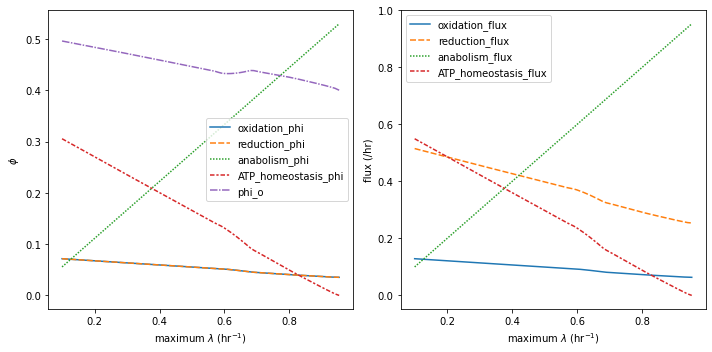

,oxidation_phi,reduction_phi,anabolism_phi,ATP_homeostasis_phi,phi_o
lambda_hr,,,,,
0.100000,0.071568,0.071568,0.055556,0.305387,0.495922
0.110000,0.071156,0.071156,0.061111,0.301869,0.494708
0.120000,0.070745,0.070745,0.066667,0.298350,0.493494
0.130000,0.070333,0.070333,0.072222,0.294832,0.492280
0.140000,0.069922,0.069922,0.077778,0.291314,0.491066
...,...,...,...,...,...
0.952941,0.035294,0.035294,0.529412,0.000000,0.400000
0.952941,0.035294,0.035294,0.529412,0.000000,0.400000
0.952941,0.035294,0.035294,0.529412,0.000000,0.400000


In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axs[0])

phi_cols = [c for c in phi_df.columns if c.endswith('phi')] + ['phi_o']
sns.lineplot(data=phi_df[phi_cols])
plt.xlabel(r'maximum $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'$\phi$')   

plt.sca(axs[1])
j_cols = [c for c in phi_df.columns if c.endswith('flux')]
sns.lineplot(data=phi_df[j_cols]*3600)
plt.xlabel(r'maximum $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'flux (/hr)')

plt.tight_layout()
plt.show()

phi_df[phi_cols]


In [6]:
# Use the SAlib tools to generate parameters for a sensitivity analysis
ps = ProblemSpec({
        "names": ["phi_o", "S6", "m_resp", "resp_ATP_per_e", "m_ATP_homeostasis"],
        "groups": None,
        "bounds": [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000],],
        "outputs": ["lambda_max"],
    })
ps.sample_sobol(64)

results = []

for phi_o, s6, m_resp, atp_per_e, m_homeo in ps.samples:
    lam.set_S6(s6)
    lam.set_process_mass('reduction', m_resp)
    lam.set_process_mass('ATP_homeostasis', m_homeo)
    lam.set_ATP_yield('reduction', atp_per_e)
    max_lam, opt_prob = lam.maximize_lambda(phi_o=phi_o)

    d = lam.solution_as_dict(opt_prob)
    d.update(lam.model_as_dict())
    d['resp_ATP_per_e'] = atp_per_e
    results.append(d)

res_df = pd.DataFrame(results)
res_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,lambda_hr,phi_o,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,ATP_homeostasis_flux,...,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,ZCB,ZCorg,ZCprod,S6,resp_ATP_per_e
0,0.164409,0.300597,0.009391,0.000005,0.598674,0.000017,0.091338,0.000046,0.000000e+00,0.000000e+00,...,7155.629059,50.0,100.0,50.0,1401.743925,-0.044855,0.0,4.0,0.022427,0.678485
1,0.154190,0.344070,0.008807,0.000004,0.561462,0.000016,0.085661,0.000043,0.000000e+00,0.000000e+00,...,7155.629059,50.0,100.0,50.0,1401.743925,-0.044855,0.0,4.0,0.022427,0.678485
2,0.180792,0.300597,0.016047,0.000008,0.582916,0.000016,0.100440,0.000050,2.497164e-11,8.907347e-16,...,7155.629059,50.0,100.0,50.0,1401.743925,-0.314648,0.0,4.0,0.157324,0.678485
3,0.916054,0.300597,0.052323,0.000026,0.138161,0.000093,0.508919,0.000254,1.040938e-09,3.713012e-14,...,296.378037,50.0,100.0,50.0,1401.743925,-0.044855,0.0,4.0,0.022427,0.678485
4,0.228928,0.300597,0.009293,0.000005,0.562928,0.000016,0.127182,0.000064,2.922423e-11,1.042424e-15,...,7155.629059,50.0,100.0,50.0,1401.743925,-0.044855,0.0,4.0,0.022427,1.064840


In [7]:
ps.set_results(res_df.lambda_hr.values)
ps.analyze_sobol(print_to_console=True, calc_second_order=True)

                         ST   ST_conf
phi_o              0.022103  0.018948
S6                 0.631063  0.290938
m_resp             0.583369  0.192270
resp_ATP_per_e     0.118474  0.077744
m_ATP_homeostasis  0.001051  0.000858
                         S1   S1_conf
phi_o             -0.007365  0.048082
S6                 0.534135  0.230109
m_resp             0.377050  0.356613
resp_ATP_per_e     0.022787  0.086483
m_ATP_homeostasis -0.002480  0.010507
                                           S2   S2_conf
(phi_o, S6)                          0.015947  0.064053
(phi_o, m_resp)                      0.036270  0.056448
(phi_o, resp_ATP_per_e)              0.013865  0.054758
(phi_o, m_ATP_homeostasis)           0.002280  0.053448
(S6, m_resp)                        -0.035678  0.294950
(S6, resp_ATP_per_e)                -0.080733  0.225353
(S6, m_ATP_homeostasis)             -0.151258  0.235307
(m_resp, resp_ATP_per_e)             0.292340  0.589179
(m_resp, m_ATP_homeostasis)          0.3

{'names': ['phi_o', 'S6', 'm_resp', 'resp_ATP_per_e', 'm_ATP_homeostasis'],
 'groups': None,
 'bounds': [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000]],
 'outputs': ['lambda_max'],
 'num_vars': 5,
 'sample_scaled': True}

<AxesSubplot: xlabel='reduction_m_kDa', ylabel='lambda_hr'>

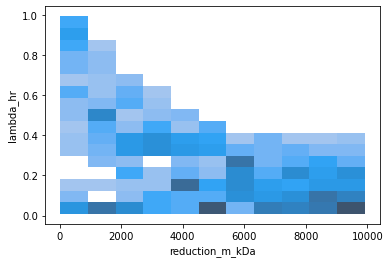

In [8]:
sns.histplot(data=res_df, y='lambda_hr', x='reduction_m_kDa', legend=False)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


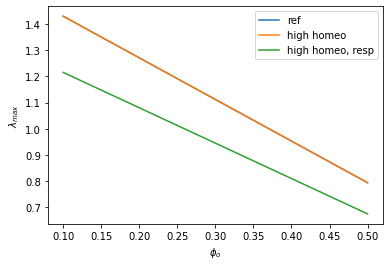

In [9]:
ref_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)

high_homeo_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_lam.set_process_mass('ATP_homeostasis', 400) # 4x baseline

high_homeo_resp_lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
high_homeo_resp_lam.set_process_mass('ATP_homeostasis', 400) # 4x baseline
high_homeo_resp_lam.set_process_mass('reduction', 400) # 4x baseline

phi_os = np.arange(0.1, 0.501, 0.1)
maint = 0.0
ref_lambdas = [ref_lam.maximize_lambda(phi_o=p, maint=maint)[0] for p in phi_os]
high_homeo_lambdas = [high_homeo_lam.maximize_lambda(phi_o=p, maint=maint)[0] for p in phi_os]
high_homeo_resp_lambdas = [high_homeo_resp_lam.maximize_lambda(phi_o=p, maint=maint)[0] for p in phi_os]

plt.plot(phi_os, ref_lambdas, label='ref')
plt.plot(phi_os, high_homeo_lambdas, label='high homeo')
plt.plot(phi_os, high_homeo_resp_lambdas, label='high homeo, resp')
plt.legend()
plt.xlabel(r'$\phi_o$')
plt.ylabel(r'$\lambda_{max}$')
plt.show()

In [10]:
ZCBs = np.arange(-1, 1.01, 0.05)
phi_os = np.arange(0.1, 0.501, 0.2)
homeo_costs = np.logspace(1, 3, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)
res_dict = dict(ZCB=[], phi_o=[], homeo_cost=[], lambda_max=[], S6=[], resp_cost=[], resp_ATP_per_e=[])

results = []

for z in ZCBs:
    for phi_o in phi_os:
        for homeo_cost in homeo_costs:
            for resp_cost in resp_costs:
                for atp_per_e in ATP_per_es:
                    try:
                        ref_lam = lmm.copy()
                        ref_lam.set_ZCB(z)
                        ref_lam.set_process_mass('reduction', resp_cost)
                        ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                        ref_lam.set_ATP_yield('reduction', atp_per_e)
                        m, opt_p = ref_lam.maximize_lambda(phi_o=phi_o)

                        d = ref_lam.model_as_dict()
                        d.update(ref_lam.solution_as_dict(opt_p))
                        d['reduction_ATP_per_e'] = atp_per_e
                        results.append(d)
                    except:
                        continue
res_df = pd.DataFrame(results)

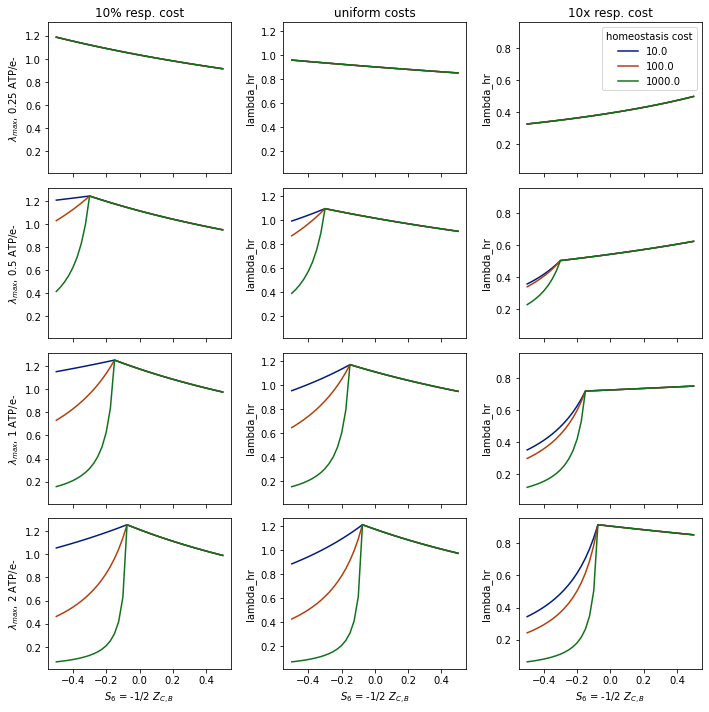

In [11]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.reduction_m_kDa == resp_cost, res_df.phi_o == phi_os[1])
        mask = np.logical_and(mask, res_df.reduction_ATP_per_e == a_per_e)
        sns.lineplot(data=res_df[mask], x='S6', y='lambda_hr', hue='ATP_homeostasis_m_kDa', palette='dark')
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\lambda_{{max}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend(title='homeostasis cost').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()

In [12]:
max_lambdas = np.linspace(0.01, 3, 50)
homeo_costs = np.logspace(1, 3, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)
res_dict = dict(ZCB=[], phi_o=[], homeo_cost=[], lambda_max=[], S6=[], resp_cost=[], resp_ATP_per_e=[])

results = []

for max_lambda in max_lambdas:
    for homeo_cost in homeo_costs:
        for resp_cost in resp_costs:
            for atp_per_e in ATP_per_es:
                try:
                    ref_lam = lmm.copy()
                    ref_lam.set_process_mass('reduction', resp_cost)
                    ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                    ref_lam.set_ATP_yield('reduction', atp_per_e)
                    m, opt_p = ref_lam.maximize_lambda(min_phi_o=0.4, max_lambda_hr=max_lambda)

                    d = ref_lam.model_as_dict()
                    d.update(ref_lam.solution_as_dict(opt_p))
                    d['reduction_ATP_per_e'] = atp_per_e
                    results.append(d)
                except:
                    continue
res_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


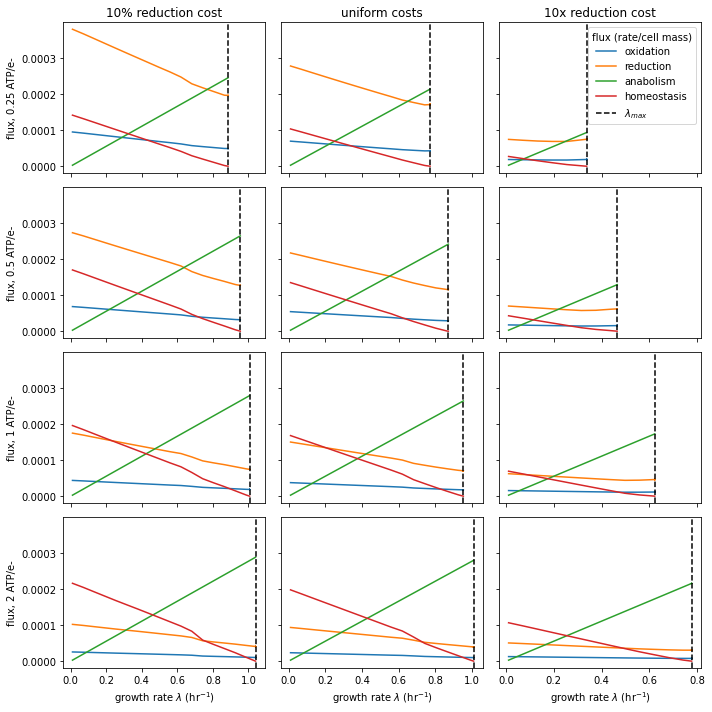

In [13]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex='col', sharey=True)

titles = '10% reduction cost,uniform costs,10x reduction cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.reduction_m_kDa == resp_cost, res_df.reduction_ATP_per_e == a_per_e)
        mask = np.logical_and(mask, res_df.ATP_homeostasis_m_kDa == 100)
        sns.lineplot(data=res_df[mask], x='lambda_hr', y='oxidation_flux', palette='dark', label='oxidation')
        sns.lineplot(data=res_df[mask], x='lambda_hr', y='reduction_flux', palette='dark', label='reduction')
        sns.lineplot(data=res_df[mask], x='lambda_hr', y='anabolism_flux', palette='dark', label='anabolism')
        sns.lineplot(data=res_df[mask], x='lambda_hr', y='ATP_homeostasis_flux', palette='dark', label='homeostasis')
        plt.axvline(res_df[mask].lambda_hr.max(), color='k', linestyle='--', label='$\lambda_{max}$')        
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'flux, {0} ATP/e-'.format(a_per_e))
        if i == 3:
            plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')

plt.sca(axs[0,2])
plt.legend(title='flux (rate/cell mass)').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_v_flux_sweep.png', dpi=300, facecolor='white')
plt.show()

<AxesSubplot: xlabel='reduction_m_kDa', ylabel='lambda_hr'>

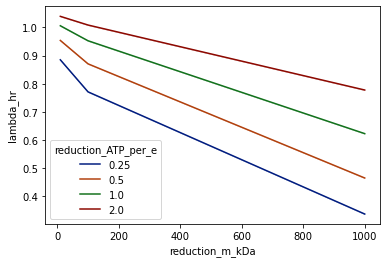

In [14]:
max_idx = res_df.groupby('reduction_m_kDa,ATP_homeostasis_m_kDa,reduction_ATP_per_e'.split(',')).lambda_hr.idxmax()
max_lambda = res_df.loc[max_idx]

sns.lineplot(data=max_lambda, x='reduction_m_kDa', y='lambda_hr', hue='reduction_ATP_per_e', palette='dark')

In [15]:
max_lambda

,oxidation_kcat_s,oxidation_m_kDa,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,ZCB,ZCorg,...,min_phi_o,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,ATP_homeostasis_flux,reduction_ATP_per_e
612,50.0,100.0,200.0,10.0,50.0,100.0,50.0,10.0,0.0,0.0,...,0.4,0.098361,0.000049,0.009836,0.000197,0.491803,0.000246,0.0,0.0,0.25
613,50.0,100.0,200.0,10.0,50.0,100.0,50.0,10.0,0.0,0.0,...,0.4,0.063604,0.000032,0.006360,0.000127,0.530035,0.000265,0.0,0.0,0.50
614,50.0,100.0,200.0,10.0,50.0,100.0,50.0,10.0,0.0,0.0,...,0.4,0.037267,0.000019,0.003727,0.000075,0.559006,0.000280,0.0,0.0,1.00
831,50.0,100.0,200.0,10.0,50.0,100.0,50.0,10.0,0.0,0.0,...,0.4,0.020385,0.000010,0.002039,0.000041,0.577576,0.000289,0.0,0.0,2.00
588,50.0,100.0,200.0,10.0,50.0,100.0,50.0,100.0,0.0,0.0,...,0.4,0.098361,0.000049,0.009836,0.000197,0.491803,0.000246,0.0,0.0,0.25
625,50.0,100.0,200.0,10.0,50.0,100.0,50.0,100.0,0.0,0.0,...,0.4,0.063604,0.000032,0.006360,0.000127,0.530035,0.000265,0.0,0.0,0.50
698,50.0,100.0,200.0,10.0,50.0,100.0,50.0,100.0,0.0,0.0,...,0.4,0.037267,0.000019,0.003727,0.000075,0.559006,0.000280,0.0,0.0,1.00
699,50.0,100.0,200.0,10.0,50.0,100.0,50.0,100.0,0.0,0.0,...,0.4,0.020385,0.000010,0.002039,0.000041,0.577576,0.000289,0.0,0.0,2.00
672,50.0,100.0,200.0,10.0,50.0,100.0,50.0,1000.0,0.0,0.0,...,0.4,0.098361,0.000049,0.009836,0.000197,0.491803,0.000246,0.0,0.0,0.25
709,50.0,100.0,200.0,10.0,50.0,100.0,50.0,1000.0,0.0,0.0,...,0.4,0.063604,0.000032,0.006360,0.000127,0.530035,0.000265,0.0,0.0,0.50
